<a href="https://colab.research.google.com/github/Pal208194/SCT_ML_3/blob/main/k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shape: (200, 6)

First few rows:
  CustomerID  PurchaseFrequency  AvgPurchaseValue    Recency  TotalSpent  \
0   CUST0001           3.590519         38.224042  19.135699   73.222686   
1   CUST0002           2.241697         55.801248  15.922734  212.829206   
2   CUST0003           2.073425         13.797891  12.871299    0.000000   
3   CUST0004           2.073453         14.813406  79.576681  115.537725   
4   CUST0005           6.974572         32.038894  53.268212  234.008437   

   CategoryVariety  
0                5  
1                3  
2                5  
3                3  
4                3  

Data summary:
       PurchaseFrequency  AvgPurchaseValue     Recency  TotalSpent  \
count         200.000000        200.000000  200.000000  200.000000   
mean            2.981890         49.065313   28.149934  155.843785   
std             1.912453         24.514416   26.846126  137.992051   
min             0.271517         10.000000    1.000000    0.000000   
25%           

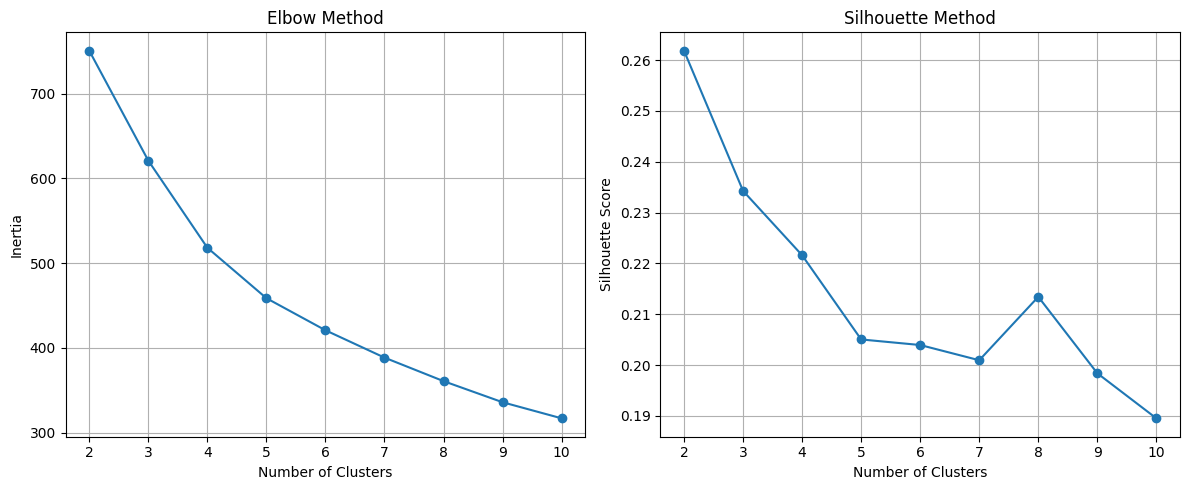


Number of clusters: 2
Cluster 0: 66 customers (33.0%)
Cluster 1: 134 customers (67.0%)
Silhouette Score: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


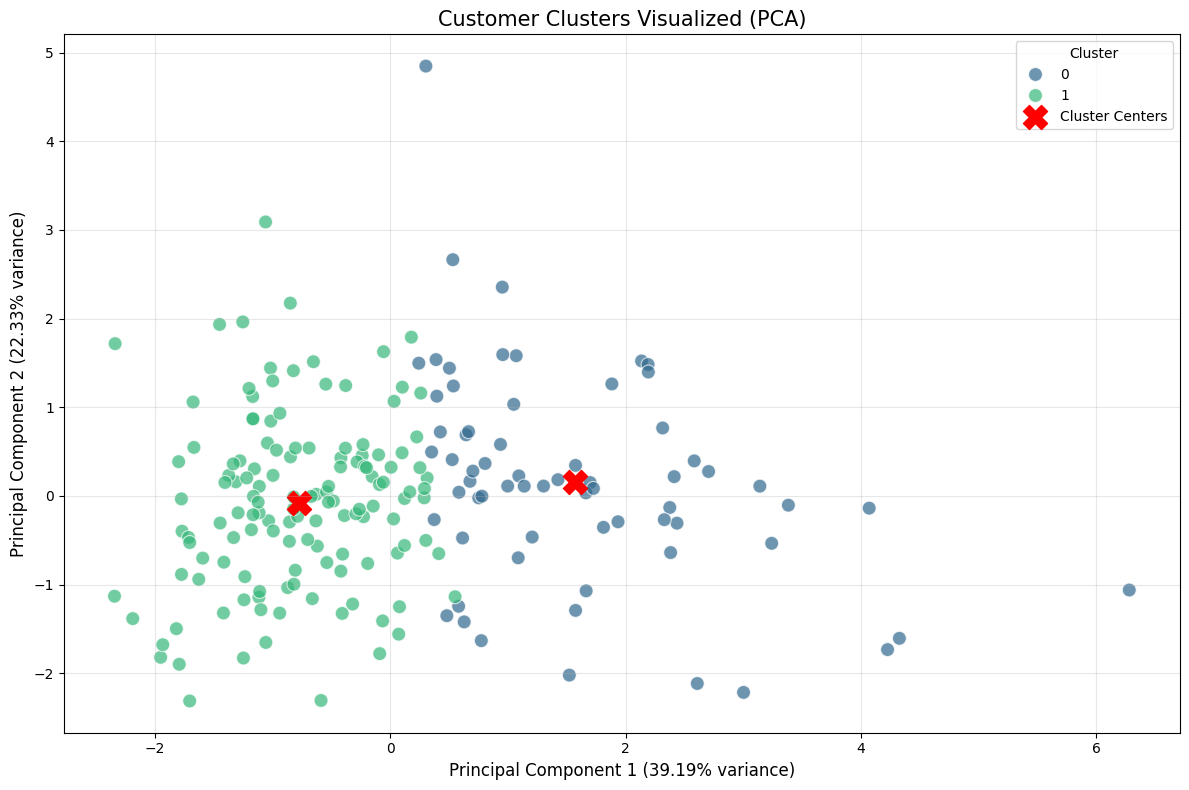

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns

# Define a function to load and preprocess the data
def load_and_preprocess_data(file_path=None, url=None):
    """
    Load customer data from a local file or URL and preprocess it.
    """
    if file_path:
        df = pd.read_csv(file_path)
    elif url:
        # Load from URL if file doesn't exist
        import requests
        import io
        response = requests.get(url)
        if response.status_code == 200:
            df = pd.read_csv(io.StringIO(response.text))
        else:
            raise Exception(f"Failed to download data: {response.status_code}")
    else:
        # Create a sample dataset if no path or URL is provided
        np.random.seed(42)
        n_samples = 200

        # Customer IDs
        customer_ids = [f'CUST{i:04d}' for i in range(1, n_samples+1)]

        # Purchase frequency (times per month)
        purchase_frequency = np.random.gamma(2, 1.5, n_samples)

        # Average purchase value
        avg_purchase_value = np.random.normal(50, 25, n_samples)
        avg_purchase_value = np.clip(avg_purchase_value, 10, 200)

        # Purchase recency (days since last purchase)
        recency = np.random.exponential(30, n_samples)
        recency = np.clip(recency, 1, 180)

        # Total spent
        total_spent = purchase_frequency * avg_purchase_value + np.random.normal(0, 50, n_samples)
        total_spent = np.clip(total_spent, 0, 5000)

        # Product categories purchased
        category_variety = np.random.poisson(3, n_samples) + 1
        category_variety = np.clip(category_variety, 1, 10)

        # Create DataFrame
        df = pd.DataFrame({
            'CustomerID': customer_ids,
            'PurchaseFrequency': purchase_frequency,
            'AvgPurchaseValue': avg_purchase_value,
            'Recency': recency,
            'TotalSpent': total_spent,
            'CategoryVariety': category_variety
        })

    print(f"Data shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())

    print("\nData summary:")
    print(df.describe())

    return df

# Define the main clustering function
def cluster_customers(df, id_column='CustomerID', features=None, n_clusters=None):
    """
    Cluster customers using K-means algorithm.

    Parameters:
    -----------
    df : pandas DataFrame
        Customer purchase data
    id_column : str
        Column name for customer identifier
    features : list
        List of feature columns to use for clustering
    n_clusters : int
        Number of clusters to create, if None will determine automatically

    Returns:
    --------
    df_clustered : pandas DataFrame
        Original data with cluster assignments
    kmeans : KMeans object
        Trained KMeans model
    scaler : StandardScaler object
        Fitted scaler for feature normalization
    """
    # Select features for clustering
    if features is None:
        # Use all numeric columns except the ID column
        features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != id_column]

    print(f"Using features for clustering: {features}")

    # Extract features
    X = df[features].copy()

    # Check for missing values
    if X.isnull().any().any():
        print("Warning: Data contains missing values. Filling with feature means.")
        X = X.fillna(X.mean())

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Determine optimal number of clusters if not specified
    if n_clusters is None:
        n_clusters = find_optimal_clusters(X_scaled, max_clusters=10)

    # Train K-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # Add cluster assignments to the original dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = clusters

    # Print cluster information
    print(f"\nNumber of clusters: {n_clusters}")
    for i in range(n_clusters):
        cluster_size = np.sum(clusters == i)
        print(f"Cluster {i}: {cluster_size} customers ({cluster_size/len(df)*100:.1f}%)")

    # Calculate and print silhouette score
    silhouette_avg = silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score: {silhouette_avg:.3f}")

    return df_clustered, kmeans, scaler

def find_optimal_clusters(X, max_clusters=10):
    """
    Find the optimal number of clusters using the elbow method and silhouette scores.
    """
    sil_scores = []
    inertias = []

    for n in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X)

        # Calculate silhouette score
        sil_score = silhouette_score(X, clusters)
        sil_scores.append(sil_score)

        # Calculate inertia (within-cluster sum of squares)
        inertias.append(kmeans.inertia_)

    # Plot elbow method
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), sil_scores, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Find optimal number of clusters
    # We'll use the silhouette score, selecting the number of clusters with the highest score
    optimal_clusters = sil_scores.index(max(sil_scores)) + 2  # +2 because we started from 2

    return optimal_clusters

def visualize_clusters(df_clustered, features, kmeans, scaler):
    """
    Visualize the clusters using PCA for dimensionality reduction.
    """
    # Extract features and scale them
    X = df_clustered[features].values
    X_scaled = scaler.transform(X)

    # Apply PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame({
        'PCA1': X_pca[:, 0],
        'PCA2': X_pca[:, 1],
        'Cluster': df_clustered['Cluster']
    })

    # Plot clusters
    plt.figure(figsize=(12, 8))

    # Scatter plot
    sns.scatterplot(
        data=pca_df,
        x='PCA1',
        y='PCA2',
        hue='Cluster',
        palette='viridis',
        s=100,
        alpha=0.7
    )

    # Plot cluster centers
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(
        centers_pca[:, 0],
        centers_pca[:, 1],
        s=300,
        c='red',
        marker='X',
        label='Cluster Centers'
    )

    plt.title('Customer Clusters Visualized (PCA)', fontsize=15)
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Feature importance for each cluster (cluster profiles)
    analyze_cluster_profiles(df_clustered, features)

def analyze_cluster_profiles(df_clustered, features):
    """
    Analyze and visualize the characteristics of each cluster.
    """
    # Calculate cluster profiles (mean values for each feature in each cluster)
    cluster_profiles = df_clustered.groupby('Cluster')[features].mean()

    # Normalize profiles for heatmap visualization
    profiles_normalized = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

    # Plot heatmap of cluster profiles
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        profiles_normalized,
        cmap='coolwarm',
        annot=cluster_profiles.round(2),
        fmt='.2f',
        linewidths=0.5,
        cbar_kws={'label': 'Standard Deviations from Mean'}
    )
    plt.title('Cluster Profiles (Feature Importance)', fontsize=15)
    plt.tight_layout()
    plt.show()

    # Plot radar charts for each cluster
    plot_radar_charts(cluster_profiles)

    # Create descriptive labels for clusters
    create_cluster_labels(cluster_profiles)

def plot_radar_charts(cluster_profiles):
    """
    Create radar charts for each cluster to visualize their characteristics.
    """
    # Normalize the data for radar charts
    normalized_profiles = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

    # Set up the radar chart
    features = normalized_profiles.columns.tolist()
    n_features = len(features)
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    n_clusters = len(normalized_profiles)
    fig, axs = plt.subplots(1, n_clusters, figsize=(n_clusters*6, 6), subplot_kw=dict(polar=True))

    if n_clusters == 1:
        axs = [axs]  # Make axs iterable if there's only one cluster

    # Colors for each cluster
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i, (idx, row) in enumerate(normalized_profiles.iterrows()):
        values = row.tolist()
        values += values[:1]  # Close the circle

        ax = axs[i]
        ax.plot(angles, values, color=colors[i], linewidth=2)
        ax.fill(angles, values, color=colors[i], alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features)
        ax.set_title(f'Cluster {idx} Profile', size=15)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def create_cluster_labels(cluster_profiles):
    """
    Create meaningful labels for each cluster based on their characteristics.
    """
    # Find the most distinctive features for each cluster
    labels = {}

    for cluster_id, profile in cluster_profiles.iterrows():
        # Find the top 2 highest values
        top_features = profile.nlargest(2).index.tolist()

        # Find the lowest value
        bottom_feature = profile.idxmin()

        # Create a descriptive label
        label = f"Cluster {cluster_id}: High {' & '.join(top_features)}, Low {bottom_feature}"
        labels[cluster_id] = label

    print("\nCluster Labels:")
    for cluster_id, label in labels.items():
        print(label)

def main():
    # Load and preprocess the data
    # If you have a specific dataset, provide the path or URL
    # Example: df = load_and_preprocess_data(file_path='customer_data.csv')
    # Example: df = load_and_preprocess_data(url='https://example.com/customer_data.csv')
    df = load_and_preprocess_data()

    # Define features for clustering
    features = ['PurchaseFrequency', 'AvgPurchaseValue', 'Recency', 'TotalSpent', 'CategoryVariety']

    # Cluster the customers
    df_clustered, kmeans, scaler = cluster_customers(df, features=features)

    # Visualize the results
    visualize_clusters(df_clustered, features, kmeans, scaler)

    # Save the results
    df_clustered.to_csv('customer_segments.csv', index=False)
    print("\nResults saved to 'customer_segments.csv'")

    return df_clustered, kmeans, scaler

if __name__ == "__main__":
    df_clustered, kmeans, scaler = main()